# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lalit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading and Initial Data Examination

In [2]:
df = pd.read_csv("spam_ham_dataset.csv")
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
df.shape

(5171, 4)

###  Visualize the distribution of spam vs. ham messages:

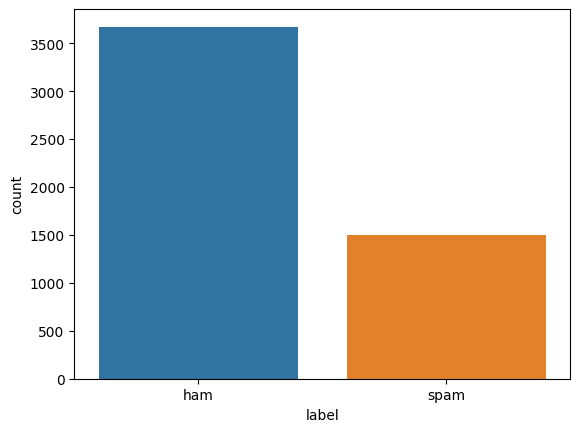

In [4]:
sns.countplot(x='label', data=df)
plt.show()


# Data Preprocessing

In [5]:
ham_msg = df[df.label_num == 0]
spam_msg = df[df.label_num == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                         random_state=42)

### Visualize the balanced dataset

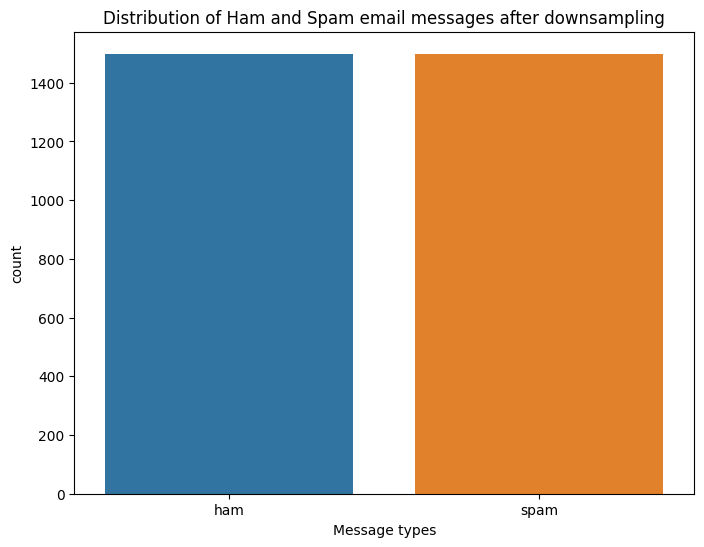

In [7]:
# Plotting the counts of the downsampled dataset
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='label')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')
plt.show()


In [8]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [9]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [10]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


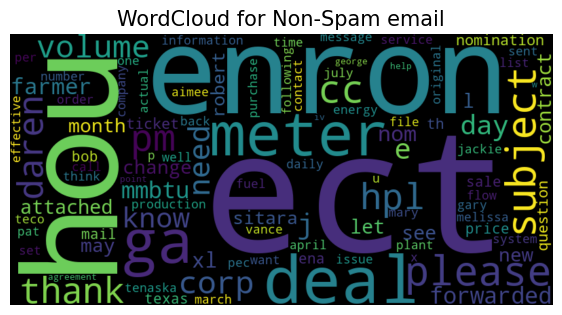

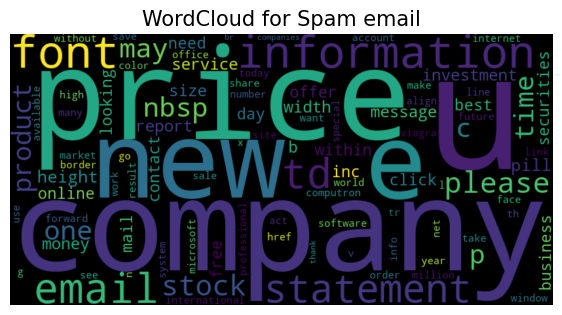

In [11]:
def plot_word_cloud(df, typ):
    sms_corpus = " ".join(df['text'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(sms_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} email', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(balanced_data[balanced_data['label_num'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label_num'] == 1], typ='Spam')

# Preparing the Data for the Model

In [12]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['label_num'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [13]:
# Tokenize the text datax
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
 
# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len, 
                                padding='post', 
                                truncating='post')
test_sequences = pad_sequences(test_sequences, 
                               maxlen=max_len, 
                               padding='post', 
                               truncating='post')


# Building the Model

In [14]:

# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1274912   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1278625 (4.88 MB)
Trainable params: 1278625 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming max_len is the desired length for your sequences
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post')


# Training the Model

In [16]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_sequences, train_Y, epochs=20, batch_size=32, validation_data=(test_sequences, test_Y))



Epoch 1/20


75/75 [==============================] - 5s 36ms/step - loss: 0.6307 - accuracy: 0.6297 - val_loss: 0.2847 - val_accuracy: 0.9700
Epoch 2/20
75/75 [==============================] - 2s 29ms/step - loss: 0.2173 - accuracy: 0.9508 - val_loss: 0.1899 - val_accuracy: 0.9550
Epoch 3/20
75/75 [==============================] - 2s 29ms/step - loss: 0.1832 - accuracy: 0.9520 - val_loss: 0.1703 - val_accuracy: 0.9500
Epoch 4/20
75/75 [==============================] - 2s 29ms/step - loss: 0.1331 - accuracy: 0.9646 - val_loss: 0.1662 - val_accuracy: 0.9533
Epoch 5/20
75/75 [==============================] - 2s 28ms/step - loss: 0.1076 - accuracy: 0.9733 - val_loss: 0.1633 - val_accuracy: 0.9550
Epoch 6/20
75/75 [==============================] - 2s 29ms/step - loss: 0.0966 - accuracy: 0.9766 - val_loss: 0.1557 - val_accuracy: 0.9600
Epoch 7/20
75/75 [==============================] - 2s 29ms/step - loss: 0.0848 - accuracy: 0.9812 - val_loss: 0.1571 - val_accuracy: 0.9600
Epoch 8/20

# Evaluating the Model

In [17]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 [==============================] - 0s 6ms/step - loss: 0.1926 - accuracy: 0.9533
Test Loss : 0.1926446259021759
Test Accuracy : 0.95333331823349


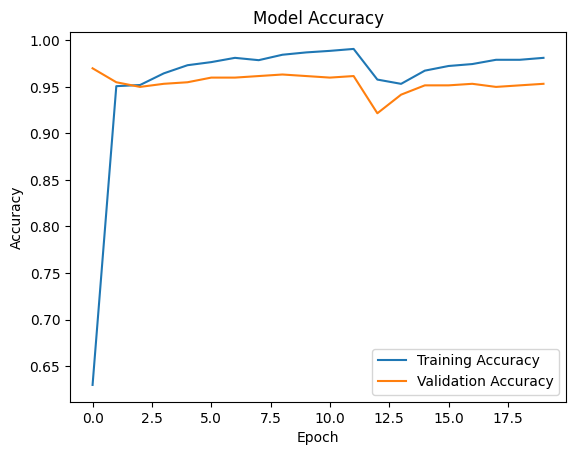

In [18]:
 
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()